In [21]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

def compute_cost_matrix_unidimensional(points_mu, points_nu, p=2):
    """
    Compute the cost matrix using a given p-norm.

    Parameters:
    -----------
    points_mu : array-like, shape (m, d)
        Coordinates of points corresponding to the distribution mu (source points).
    points_nu : array-like, shape (n, d)
        Coordinates of points corresponding to the distribution nu (target points).
    p : float, optional (default=2)
        The p-norm to use for computing the cost (e.g., p=2 for Euclidean distance, p=1 for Manhattan distance).
    
    Returns:
    --------
    cost_matrix : array, shape (m, n)
        The cost matrix where cost_matrix[i, j] is the distance (cost) between points_mu[i] and points_nu[j].
    """
    m = len(points_mu)
    n = len(points_nu)
    
    cost_matrix = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            # Compute the p-norm distance between point i in mu and point j in nu
            cost_matrix[i, j] = abs(points_mu[i] - points_nu[j])**p
    return cost_matrix


def wasserstein_distance(mu, nu, cost_matrix):
    """
    Compute the 1-Wasserstein distance between two discrete distributions using Gurobi.

    Parameters:
    -----------
    mu : array-like, shape (m,)
        Probability distribution of the first set of points (source).
    nu : array-like, shape (n,)
        Probability distribution of the second set of points (target).
    cost_matrix : array-like, shape (m, n)
        The cost matrix where cost_matrix[i][j] is the cost of transporting mass from
        point i in mu to point j in nu.
    
    Returns:
    --------
    wasserstein_distance : float
        The computed Wasserstein distance between mu and nu.
    transport_plan : array, shape (m, n)
        The optimal transport plan.
    """
    m = len(mu)
    n = len(nu)

    # Create a Gurobi model
    model = gp.Model("wasserstein")

    # Disable Gurobi output (comment this if you want to see Gurobi's solver output)
    model.setParam("OutputFlag", 0)

    # Decision variables: transport plan gamma_ij
    gamma = model.addVars(m, n, lb=0, ub=GRB.INFINITY, name="gamma")

    # Objective: minimize the sum of the transport costs
    model.setObjective(gp.quicksum(cost_matrix[i, j] * gamma[i, j] for i in range(m) for j in range(n)), GRB.MINIMIZE)

    # Constraints: ensure that the total mass transported from each mu_i matches the corresponding mass in mu
    for i in range(m):
        model.addConstr(gp.quicksum(gamma[i, j] for j in range(n)) == mu[i], name=f"supply_{i}")

    # Constraints: ensure that the total mass transported to each nu_j matches the corresponding mass in nu
    for j in range(n):
        model.addConstr(gp.quicksum(gamma[i, j] for i in range(m)) == nu[j], name=f"demand_{j}")

    # Solve the optimization model
    model.optimize()

    # Extract the optimal transport plan and the Wasserstein distance
    if model.status == GRB.OPTIMAL:
        transport_plan = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                transport_plan[i, j] = gamma[i, j].X
        wasserstein_distance = model.objVal
        return wasserstein_distance, transport_plan
    else:
        raise Exception("Optimization problem did not converge!")


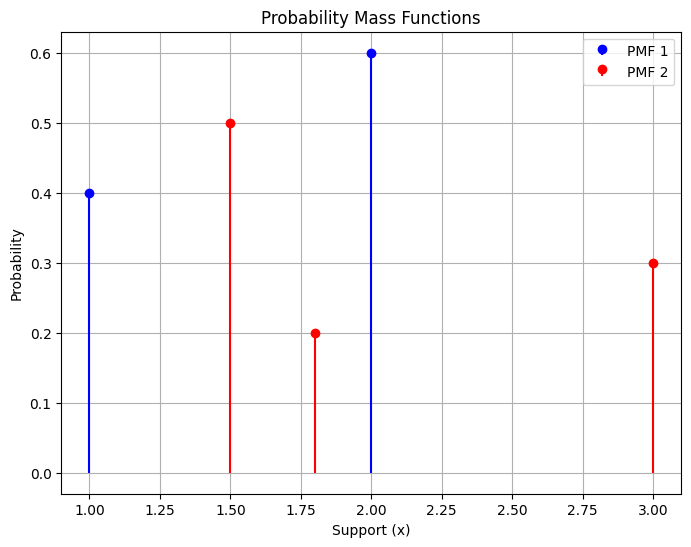

Wasserstein Distance: 0.433
Optimal Transport Plan:
[[0.4 0.  0. ]
 [0.1 0.2 0.3]]


In [28]:
# Two discrete distributions
mu = np.array([0.4, 0.6])   # Distribution over source points
points_mu = np.array([1, 2])

nu = np.array([0.5, 0.2, 0.3])  # Distribution over target points
points_nu = np.array([1.5, 1.8, 3])

# Create the plot
plt.figure(figsize=(8, 6))
    
# Plot the first PMF
plt.stem(points_mu, mu, linefmt='blue', markerfmt='blue', basefmt=" ", label="PMF 1")
plt.stem(points_nu, nu, linefmt='red', markerfmt='red', basefmt=" ", label="PMF 2")
    
# Add titles and labels
plt.title("Probability Mass Functions")
plt.xlabel("Support (x)")
plt.ylabel("Probability")

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


# Cost matrix (e.g., Euclidean distances between points)
cost_matrix = compute_cost_matrix_unidimensional(points_mu, points_nu, p=2)

# Compute the Wasserstein distance and the optimal transport plan
dist, plan = wasserstein_distance(mu, nu, cost_matrix)

# Output the results
print(f"Wasserstein Distance: {dist}")
print("Optimal Transport Plan:")
print(plan)